# More realistic baseline PE graph for 1 Node

This notebook plots a available pe time graph for a single node

In [91]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
import seaborn as sns

import glob
from os import path

import datetime

%matplotlib inline

In [92]:
# Paths

database_path = r"/home/overlytic/thesis/download/database2"

squeue_path = database_path+"/squeue"
sprio_path = database_path+"/sprio"
sshare_path = database_path+"/sshare"
sacct_path = database_path+"/sacct"

# Get Data2: Acct

In [93]:
sacct_files = glob.glob(sacct_path+"/*allpipe2*.txt")
# sacct_files = glob.glob(sacct_path+"/*test_read*")

sacct_latest_file = sacct_files[0] # MANUAL PICK LATEST

In [94]:
sacct_latest_file

'/home/overlytic/thesis/download/database2/sacct/acct_allpipe2_20210501_0606.txt'

In [95]:
SACCT_DATE_FORMAT = '%Y-%m-%dT%H:%M:%S'
TIME_FORMAT = '%H:%M:%S'
TIME_FORMAT_LONG = '%d-%H:%M:%S'

def read_sacct(file, top_n = None):
    sacct_list = []
    
    i = 0
    with open(file, "r") as sacct_lines:        
        for line in sacct_lines:
            stripped = line.strip()
            if stripped[-1] == "|":
                stripped = stripped[:-1]
            sacct_list.append(stripped.split("|"))
            
            i+=1
            if (top_n != None and i > top_n): break
            
    return sacct_list

def compile_sacct_df(data_list):
    cols = data_list[0]
    data = data_list[1:]
    
    sacct_dict = [dict(zip(cols, x)) for x in data]

    df = pd.DataFrame(sacct_dict)
    
    return df

In [96]:
# Read Acct csv
sacct_list = read_sacct(sacct_latest_file)
sacct_df_raw = compile_sacct_df(sacct_list)

In [97]:
# Read Parameters

NODE_COUNT = 1 # clust_params.CLUSTINFO_NODE_COUNT.values[0]
NODE_CPUS = 32 # clust_params.CLUSTINFO_NODE_CPUS.values[0]
NODE_MEM_MB = 237568 # clust_params.CLUSTINFO_NODE_MEM_MB.values[0]
DEFAULT_MEM_PER_CPU = 7424 # clust_params.CLUSTINFO_NODE_DEF_MEM_PER_CPU.values[0]

def calc_pe_req(cpus_req, mem_req, nodes_req):
    pe_max = NODE_CPUS * NODE_COUNT
    
    job_pe_req = max([cpus_req / NODE_CPUS, mem_req / NODE_MEM_MB]) * nodes_req * NODE_CPUS
    
    return job_pe_req

def timeformat_to_seconds(x):
    """Converts d-%H:%M:%S time format into total seconds"""
    
    stripped = x.strip()
    try:
        str_days = re.findall("([0-9]+)-(.+)", stripped)[0][0]
    except IndexError:
        str_days = '0'
        
    days = int(str_days) if len(str_days) > 0 else 0
    
    try:
        str_hms = re.findall(r"([0-9]?[0-9]?:?[0-9]?[0-9]:[0-9]?[0-9])", stripped)[0]
        
        str_hms = "0"+str_hms if str_hms[1] == ":" else str_hms
        str_hms = "00:"+str_hms if str_hms.count(":") == 1 else str_hms
        
        hms = datetime.datetime.strptime(str_hms, TIME_FORMAT)
        delta = datetime.timedelta(days=days, hours=hms.hour, minutes=hms.minute, seconds=hms.second)
        tot_sec = delta.total_seconds()
    
    except IndexError:
        tot_sec = np.NaN
    
    return tot_sec
    
def convert_columns_sacct(df):    
    """ Function converts string columns in sacct df to better datatypes"""
    # Existing columns
    
    ## Numeric columns
    
    df.JobIDRaw = pd.to_numeric(df.JobIDRaw)
    df.ReqCPUS = pd.to_numeric(df.ReqCPUS)
    df.ReqNodes = pd.to_numeric(df.ReqNodes)
    df.Priority = pd.to_numeric(df.Priority)
#     df.MaxRSS = pd.to_numeric(df.MaxRSS)
    
    ## Character columns
    df.State = df.State.str.extract('([^ ]+)') # CANCELLED by 010101 -> CANCELLED
        
    # New Columns:
    df['ReqCpuNode'] = pd.to_numeric(df.ReqCPUS) / df.ReqNodes
    df.ReqCpuNode = df.ReqCpuNode.round(0).astype(int)
    
    # Numeric columns
    df['ReqMemNode'] = df.ReqTRES.str.extract("(.+)mem=(.+)M,node(.+)")[1]
    df.ReqMemNode = df.ReqMemNode.fillna(df.ReqMem.str.extract("(.+)Mn")[0])
    df.ReqMemNode = pd.to_numeric(df.ReqMemNode, errors='coerce') / df.ReqNodes
    df.ReqMemNode = df.ReqMemNode.round(0).astype(int, errors='ignore')
    
    # Calculate Job PE  -> Assumes 1 NODE!! 
    # df['pe_req'] = df.apply(lambda x: calc_pe_req(x.ReqCpuNode, x.ReqMemNode, x.ReqNodes), axis=1)
    df['pe_req_node'] = df.apply(lambda x: calc_pe_req(x.ReqCpuNode, x.ReqMemNode, 1), axis=1)
    df['pet_node'] = lambda x: x.pe_req_node * x.elapsed_time
    
    ## Date columns
    df['submit_date'] = pd.to_datetime(df.Submit, format=SACCT_DATE_FORMAT, errors = "coerce")
    df['eligible_date'] = pd.to_datetime(df.Eligible, format=SACCT_DATE_FORMAT, errors = "coerce")
    df['start_date'] = pd.to_datetime(df.Start, format=SACCT_DATE_FORMAT, errors = "coerce")
    df['end_date'] = pd.to_datetime(df.End, format=SACCT_DATE_FORMAT, errors = "coerce")
    
    ## Time columns
    df['wait_time'] = df.start_date - df.eligible_date
    df.wait_time = df.wait_time.apply(lambda x: x.total_seconds())
        
    ## Time conversion columns
    df['elapsed_time'] = df.Elapsed.apply(timeformat_to_seconds)
    df['time_limit'] = df.Timelimit.apply(timeformat_to_seconds)
    
    return df

In [98]:
# print(timeformat_to_seconds("05:00:00"))
# print(5*60*60)

# print(timeformat_to_seconds("5:00:00"))
# print(5*60*60)

# print(timeformat_to_seconds("1-05:00:00"))
# print(3600*24 + 5*60*60)

# print(timeformat_to_seconds("1-5:00:00"))
# print(3600*24 + 5*60*60)

# print(timeformat_to_seconds("21:00"))
# print(21*60)

# print(timeformat_to_seconds("1:1:1"))
# print(3600+60+1)

In [99]:
# sacct_df_raw.loc[sacct_df_raw.JobIDRaw == "222189"]

In [100]:
# Convert Acct 
sacct_df_raw2 = (sacct_df_raw
                 .copy()
             [['JobIDRaw',
               'JobID', 
               'Account',
               'User',
               'Partition',
               'Group',
               'ReqMem',
               'ReqCPUS',
               'ReqNodes',
               'Timelimit',
               'ReqTRES',
               'AllocTRES',
               'QOS',
               'Priority',
               'Submit',
               'Eligible',
               'Start',
               'End',
               'Elapsed',
               'State',
               'NodeList'
               ]]
              .pipe(convert_columns_sacct))

print("Invalid Submit Dates: ", sacct_df_raw2[sacct_df_raw2.submit_date.isna()].Submit.unique())
print("Invalid Eligible Dates: ", sacct_df_raw2[sacct_df_raw2.eligible_date.isna()].Eligible.unique())
print("Invalid Start Dates: ", sacct_df_raw2[sacct_df_raw2.start_date.isna()].Start.unique())
print("Invalid End Dates: ", sacct_df_raw2[sacct_df_raw2.end_date.isna()].End.unique())
print("Invalid Timelimit: ", sacct_df_raw2[sacct_df_raw2.time_limit.isna()].Timelimit.unique())
print("Missing ReqMemNode, showing ReqMem: ", sacct_df_raw2[sacct_df_raw2.ReqMemNode.isna()].ReqMem.unique())

# Final Cleaned
sacct_df = sacct_df_raw2

Invalid Submit Dates:  []
Invalid Eligible Dates:  []
Invalid Start Dates:  ['Unknown']
Invalid End Dates:  ['Unknown']
Invalid Timelimit:  ['UNLIMITED']
Missing ReqMemNode, showing ReqMem:  ['0n']


In [101]:
# sacct_df_raw2[sacct_df_raw2.ReqMem == '0n']

In [102]:
# pd.options.display.max_columns=200
# sacct_df_raw.NodeList

In [103]:
# # pd.options.display.max_columns=100
# sacct_df.head(10)
# sacct_df.info()

In [104]:
np.max([0.5, 0.3])

0.5

In [105]:
np.max([47104.00 / NODE_MEM_MB, 12 / 32]) * 32

12.0

In [106]:
sacct_df[sacct_df.JobID == "222095"]

,JobIDRaw,JobID,Account,User,Partition,Group,ReqMem,ReqCPUS,ReqNodes,Timelimit,ReqTRES,AllocTRES,QOS,Priority,Submit,Eligible,Start,End,Elapsed,State,NodeList,ReqCpuNode,ReqMemNode,pe_req_node,pet_node,submit_date,eligible_date,start_date,end_date,wait_time,elapsed_time,time_limit
2745,222095,222095,b09-mightee-ag,russ,Main,idia-group,47104Mn,48,4,1-00:00:00,"billing=48,cpu=48,mem=188416M,node=4","billing=48,cpu=48,mem=188416M,node=4",normal,484,2021-04-30T23:34:20,2021-05-01T00:55:09,2021-05-01T01:03:53,2021-05-01T01:09:19,00:05:26,COMPLETED,"compute-[012,024,026,032]",12,47104.00,12.00,<function convert_columns_sacct.<locals>.<lamb...,2021-04-30 23:34:20,2021-05-01 00:55:09,2021-05-01 01:03:53,2021-05-01 01:09:19,524.00,326.00,86400.00


# Node Selection

In [107]:
# sacct_df.NodeList.unique()

sacct_df.NodeList.str.contains('\[').sum()

sacct_df.NodeList[sacct_df.NodeList.str.contains('\[')]

#.loc(lambda x: x == True)

167       compute-[004,030,033,062]
168       compute-[027,034,066,071]
2608          compute-[013,027,070]
2609          compute-[013,027,043]
2610          compute-[028,034,042]
                    ...            
255348            compute-[013-014]
255351        compute-[027,030,046]
255353        compute-[027,030,046]
255355        compute-[018,032,036]
255652            compute-[001,047]
Name: NodeList, Length: 4856, dtype: object

In [108]:
pd.options.display.max_rows=100

(sacct_df
 #.loc[[167],:]
 .NodeList
 .str.extractall("([0-9][0-9][0-9])")
 .reset_index(drop=True)
 .loc[:,[0]]
 .value_counts(sort=True)
 .head(20)
)

009    11032
012     9762
013     8232
005     7911
032     7846
024     7787
015     7147
008     6989
001     6779
014     6635
007     6603
026     6087
025     6017
006     5882
056     5776
030     5741
038     4812
033     4580
022     4380
010     4325
dtype: int64

In [109]:
# PARAMETERS: Node to plot

plot_node = '012'

sacct_df_node = (sacct_df[sacct_df.NodeList.str.contains(plot_node)
                        & sacct_df.elapsed_time > 0
                        ].copy()
                )

sacct_df_node.shape[0]

9759

In [110]:
(100000 / (3600*24))

# 3 day to 1 hour
# (100000 / (3600*24))

1.1574074074074074

In [111]:
sacct_df_node.sort_values('elapsed_time', ascending=False).head(20)

,JobIDRaw,JobID,Account,User,Partition,Group,ReqMem,ReqCPUS,ReqNodes,Timelimit,ReqTRES,AllocTRES,QOS,Priority,Submit,Eligible,Start,End,Elapsed,State,NodeList,ReqCpuNode,ReqMemNode,pe_req_node,pet_node,submit_date,eligible_date,start_date,end_date,wait_time,elapsed_time,time_limit
141872,365327,365327,b88-cbio-008-ag,jess,Main,cbio-group,40960Mn,16,1,1-12:00:00,"billing=16,cpu=16,mem=40960M,node=1","billing=16,cpu=16,mem=40960M,node=1",normal,82382,2021-05-22T12:42:20,2021-05-22T12:42:20,2021-05-22T12:42:20,2021-05-24T00:42:26,1-12:00:06,TIMEOUT,compute-012,16,40960.00,16.00,<function convert_columns_sacct.<locals>.<lamb...,2021-05-22 12:42:20,2021-05-22 12:42:20,2021-05-22 12:42:20,2021-05-24 00:42:26,0.00,129606.00,129600.00
156995,380511,380511,b88-cbio-008-ag,jess,Main,cbio-group,40960Mn,16,1,1-12:00:00,"billing=16,cpu=16,mem=40960M,node=1","billing=16,cpu=16,mem=40960M,node=1",normal,82399,2021-05-25T13:34:38,2021-05-25T13:34:38,2021-05-25T17:16:52,2021-05-27T04:19:47,1-11:02:55,COMPLETED,compute-012,16,40960.00,16.00,<function convert_columns_sacct.<locals>.<lamb...,2021-05-25 13:34:38,2021-05-25 13:34:38,2021-05-25 17:16:52,2021-05-27 04:19:47,13334.00,126175.00,129600.00
146651,370754,370754,b88-cbio-008-ag,jess,Main,cbio-group,40960Mn,16,1,1-12:00:00,"billing=16,cpu=16,mem=40960M,node=1","billing=16,cpu=16,mem=40960M,node=1",normal,82382,2021-05-24T04:14:44,2021-05-24T04:14:44,2021-05-24T13:11:13,2021-05-25T22:50:27,1-09:39:14,COMPLETED,compute-012,16,40960.00,16.00,<function convert_columns_sacct.<locals>.<lamb...,2021-05-24 04:14:44,2021-05-24 04:14:44,2021-05-24 13:11:13,2021-05-25 22:50:27,32189.00,121154.00,129600.00
141915,365371,365371,b88-cbio-008-ag,jess,Main,cbio-group,40960Mn,16,1,1-12:00:00,"billing=16,cpu=16,mem=40960M,node=1","billing=16,cpu=16,mem=40960M,node=1",normal,82382,2021-05-22T16:19:08,2021-05-22T16:19:08,2021-05-22T16:19:09,2021-05-24T01:42:15,1-09:23:06,COMPLETED,compute-012,16,40960.00,16.00,<function convert_columns_sacct.<locals>.<lamb...,2021-05-22 16:19:08,2021-05-22 16:19:08,2021-05-22 16:19:09,2021-05-24 01:42:15,1.00,120186.00,129600.00
77411,299132,299132,b56-cbio-001-ag,mamana,Main,cbio-group,12288Mn,2,1,2-00:00:00,"billing=2,cpu=2,mem=12288M,node=1","billing=2,cpu=2,mem=12288M,node=1",normal,86344,2021-05-15T06:43:48,2021-05-15T06:43:48,2021-05-15T06:43:50,2021-05-16T13:37:29,1-06:53:39,COMPLETED,compute-012,2,12288.00,2.00,<function convert_columns_sacct.<locals>.<lamb...,2021-05-15 06:43:48,2021-05-15 06:43:48,2021-05-15 06:43:50,2021-05-16 13:37:29,2.00,111219.00,172800.00
242267,469257,469257,b88-cbio-008-ag,jess,Main,cbio-group,56320Mn,16,1,4-00:00:00,"billing=16,cpu=16,mem=56320M,node=1","billing=16,cpu=16,mem=56320M,node=1",normal,82449,2021-06-03T06:35:13,2021-06-03T06:35:13,2021-06-03T06:35:14,2021-06-04T10:18:08,1-03:42:54,COMPLETED,compute-012,16,56320.00,16.00,<function convert_columns_sacct.<locals>.<lamb...,2021-06-03 06:35:13,2021-06-03 06:35:13,2021-06-03 06:35:14,2021-06-04 10:18:08,1.00,99774.00,345600.00
237562,463837,463837,b88-cbio-008-ag,jess,Main,cbio-group,56320Mn,16,1,4-00:00:00,"billing=16,cpu=16,mem=56320M,node=1","billing=16,cpu=16,mem=56320M,node=1",normal,82450,2021-06-01T23:58:19,2021-06-01T23:58:19,2021-06-01T23:58:49,2021-06-03T00:28:51,1-00:30:02,COMPLETED,compute-012,16,56320.00,16.00,<function convert_columns_sacct.<locals>.<lamb...,2021-06-01 23:58:19,2021-06-01 23:58:19,2021-06-01 23:58:49,2021-06-03 00:28:51,30.00,88202.00,345600.00
59337,280998,280998,b88-cbio-008-ag,jess,Main,cbio-group,61440Mn,16,1,1-00:00:00,"billing=16,cpu=16,mem=61440M,node=1","billing=16,cpu=16,mem=61440M,node=1",normal,82415,2021-05-13T11:14:42,2021-05-13T11:14:42,2021-05-13T11:15:04,2021-05-14T11:15:26,1-00:00:22,TIMEOUT,compute-012,16,61440.00,16.00,<function convert_columns_sacct.<locals>.<lamb...,2021-05-13 11:14:42,2021-05-13 11:14:42,2021-05-13 11:15:04,2021-05-14 11:15:26,22.00,86422.00,86400.00
217976,443431,443431,b88-cbio-008-ag,jess,Main,cbio-group,40960Mn,1

In [112]:
# sacct_df_node.sort_values('elapsed_time', ascending=False).head(20)

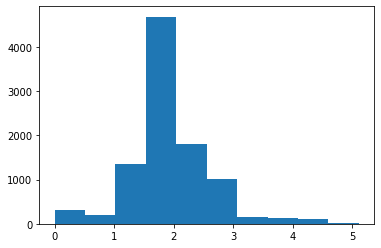

In [113]:
plt.hist(np.log10(sacct_df_node.elapsed_time))
plt.show()

In [114]:
pd.options.display.max_columns=200

sacct_df_node[sacct_df_node.ReqMemNode > NODE_MEM_MB]

,JobIDRaw,JobID,Account,User,Partition,Group,ReqMem,ReqCPUS,ReqNodes,Timelimit,ReqTRES,AllocTRES,QOS,Priority,Submit,Eligible,Start,End,Elapsed,State,NodeList,ReqCpuNode,ReqMemNode,pe_req_node,pet_node,submit_date,eligible_date,start_date,end_date,wait_time,elapsed_time,time_limit


In [115]:
# sacct_df_node.ReqMemNode.max()

In [116]:
# sacct_df_node.ReqMemNode

In [117]:
# sacct_df_node.ReqMemNode

In [118]:
# Plot the 

# Quick Check for Remaining Errors

In [119]:
print("Invalid Submit Dates: ", sacct_df_node[sacct_df_node.submit_date.isna()].Submit.unique())
print("Invalid Eligible Dates: ", sacct_df_node[sacct_df_node.eligible_date.isna()].Eligible.unique())
print("Invalid Start Dates: ", sacct_df_node[sacct_df_node.start_date.isna()].Start.unique())
print("Invalid End Dates: ", sacct_df_node[sacct_df_node.end_date.isna()].End.unique())
print("Invalid Timelimit: ", sacct_df_node[sacct_df_node.time_limit.isna()].Timelimit.unique())
print("Missing ReqMemNode, showing ReqMem: ", sacct_df_node[sacct_df_node.ReqMemNode.isna()].ReqMem.unique())

Invalid Submit Dates:  []
Invalid Eligible Dates:  []
Invalid Start Dates:  []
Invalid End Dates:  []
Invalid Timelimit:  []
Missing ReqMemNode, showing ReqMem:  []


In [120]:
# Check CPU
sacct_df_node['ReqCpuNode'].describe()

count   9759.00
mean       4.91
std        5.98
min        1.00
25%        1.00
50%        2.00
75%        4.00
max       32.00
Name: ReqCpuNode, dtype: float64

In [121]:
# Check Mem
sacct_df_node['ReqMemNode'].describe()

count     9759.00
mean     34044.11
std      46629.14
min        100.00
25%      14336.00
50%      28672.00
75%      36864.00
max     237568.00
Name: ReqMemNode, dtype: float64

In [122]:
# Check PE
sacct_df_node['pe_req_node'].describe()

count   9759.00
mean       5.82
std        6.93
min        1.00
25%        2.00
50%        4.00
75%        6.34
max       32.00
Name: pe_req_node, dtype: float64

In [123]:
# PE Errors
sacct_df_node[sacct_df_node.pe_req_node > 32]

,JobIDRaw,JobID,Account,User,Partition,Group,ReqMem,ReqCPUS,ReqNodes,Timelimit,ReqTRES,AllocTRES,QOS,Priority,Submit,Eligible,Start,End,Elapsed,State,NodeList,ReqCpuNode,ReqMemNode,pe_req_node,pet_node,submit_date,eligible_date,start_date,end_date,wait_time,elapsed_time,time_limit


# Convert to PE Time DataFrame

In [124]:
sacct_df_node.State

2537      COMPLETED
2538      COMPLETED
2539      COMPLETED
2540      COMPLETED
2542      COMPLETED
            ...    
255500    COMPLETED
255514    COMPLETED
255661    COMPLETED
255670    COMPLETED
255677    COMPLETED
Name: State, Length: 9759, dtype: object

In [125]:
def convert_sacct_to_pe_time(sacct, pe_column = "pe_req", init_pe=NODE_CPUS, elapsed_column = "elapsed_time"):

    df_start = (sacct[['JobID', pe_column, elapsed_column, 'start_date']]
                .rename(columns = {'start_date':'event_time',
                                   pe_column : 'pe_req'})
                .assign(event_id = 10, 
                        event_type = 'start')
                .assign(comment_jobid = lambda x: x.JobID)
                .assign(comment_runtime = lambda x: x[elapsed_column])
                .assign(pe_delta = lambda x: -1 * x.pe_req)
                .drop(columns=['pe_req', 'JobID', elapsed_column])
               )

    df_end = (sacct[['JobID', pe_column, elapsed_column, 'end_date']]
                .rename(columns = {'end_date':'event_time',
                                   pe_column : 'pe_req'})
                .assign(event_id = 9, 
                        event_type = 'end')
                .assign(comment_jobid = lambda x: x.JobID)
                .assign(comment_runtime = lambda x: x[elapsed_column])
                .assign(pe_delta = lambda x: +1 * x.pe_req)
                .drop(columns=['pe_req', 'JobID', elapsed_column])
               )

    min_event_time = pd.to_datetime(df_start.event_time.min().value)

    df_initial = pd.DataFrame({'event_time' : [min_event_time],
                               'event_id' : [0],
                               'event_type' : ['init'],
                               'comment_jobid' : [np.nan],
                               'comment_runtime' : [np.nan],
                               'pe_delta' : init_pe
                               })

    # df_event = pd.concat([df_start 
    df_pe_time = (pd.concat([df_initial, 
                            df_start, 
                            df_end])
                 .sort_values(['event_time', 'event_id', 'comment_jobid'])
                 .reset_index(drop=True)
                )

    # calculate available pe

    df_pe_time['pe_avail'] = df_pe_time.pe_delta.cumsum()
    df_pe_time['pe_avail_norm'] = df_pe_time.pe_avail /  df_pe_time.pe_avail.max()
    # df_pe_time['pe_avail_norm'] = df_pe_time.pe_avail /  NODE_CPUS
    
    return df_pe_time

In [126]:
sacct_df_node.columns

Index(['JobIDRaw', 'JobID', 'Account', 'User', 'Partition', 'Group', 'ReqMem',
       'ReqCPUS', 'ReqNodes', 'Timelimit', 'ReqTRES', 'AllocTRES', 'QOS',
       'Priority', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'State',
       'NodeList', 'ReqCpuNode', 'ReqMemNode', 'pe_req_node', 'pet_node',
       'submit_date', 'eligible_date', 'start_date', 'end_date', 'wait_time',
       'elapsed_time', 'time_limit'],
      dtype='object')

In [127]:
# sacct_df_node2

In [128]:
# Create PE Time Graphs

filter_first_start = '2021-06-01'
filter_last_start = '2021-06-03'

sacct_df_node2 = sacct_df_node.loc[(sacct_df_node.start_date >= filter_first_start) & 
                                   (sacct_df_node.start_date <= filter_last_start)].copy()

df_cpu_time = convert_sacct_to_pe_time(sacct_df_node2, 'ReqCpuNode', NODE_CPUS)
df_mem_time = convert_sacct_to_pe_time(sacct_df_node2, 'ReqMemNode', NODE_MEM_MB)

df_pe_time = convert_sacct_to_pe_time(sacct_df_node2, 'pe_req_node')

In [129]:
df_cpu_time.loc[20:30, :]

,event_time,event_id,event_type,comment_jobid,comment_runtime,pe_delta,pe_avail,pe_avail_norm
20,2021-06-01 01:56:45,10,start,451846,338.00,-1,9,0.28
21,2021-06-01 01:56:48,9,end,454337,6516.00,1,10,0.31
22,2021-06-01 01:56:48,9,end,454637,3539.00,1,11,0.34
23,2021-06-01 01:57:16,10,start,454718,375.00,-1,10,0.31
24,2021-06-01 02:02:08,9,end,451835,353.00,1,11,0.34
25,2021-06-01 02:02:16,10,start,451836,252.00,-6,5,0.16
26,2021-06-01 02:02:23,9,end,451846,338.00,1,6,0.19
27,2021-06-01 02:02:46,10,start,451847,254.00,-6,0,0.00
28,2021-06-01 02:03:31,9,end,454718,375.00,1,1,0.03
29,2021-06-01 02:03:47,10,start,454726,2157.00,-1,0,0.00


In [130]:
df_mem_time.loc[20:30, :]

,event_time,event_id,event_type,comment_jobid,comment_runtime,pe_delta,pe_avail,pe_avail_norm
20,2021-06-01 01:56:45,10,start,451846,338.00,-29696.00,16384.00,0.07
21,2021-06-01 01:56:48,9,end,454337,6516.00,6144.00,22528.00,0.09
22,2021-06-01 01:56:48,9,end,454637,3539.00,51200.00,73728.00,0.31
23,2021-06-01 01:57:16,10,start,454718,375.00,-51200.00,22528.00,0.09
24,2021-06-01 02:02:08,9,end,451835,353.00,29696.00,52224.00,0.22
25,2021-06-01 02:02:16,10,start,451836,252.00,-29696.00,22528.00,0.09
26,2021-06-01 02:02:23,9,end,451846,338.00,29696.00,52224.00,0.22
27,2021-06-01 02:02:46,10,start,451847,254.00,-29696.00,22528.00,0.09
28,2021-06-01 02:03:31,9,end,454718,375.00,51200.00,73728.00,0.31
29,2021-06-01 02:03:47,10,start,454726,2157.00,-51200.00,22528.00,0.09


In [131]:
# Display

# pd.options.display.max_rows=1000
# df_pe_time
df_pe_time.loc[20:30, :]

,event_time,event_id,event_type,comment_jobid,comment_runtime,pe_delta,pe_avail,pe_avail_norm
20,2021-06-01 01:56:45,10,start,451846,338.00,-4.00,-8.79,-0.27
21,2021-06-01 01:56:48,9,end,454337,6516.00,1.00,-7.79,-0.24
22,2021-06-01 01:56:48,9,end,454637,3539.00,6.90,-0.90,-0.03
23,2021-06-01 01:57:16,10,start,454718,375.00,-6.90,-7.79,-0.24
24,2021-06-01 02:02:08,9,end,451835,353.00,4.00,-3.79,-0.12
25,2021-06-01 02:02:16,10,start,451836,252.00,-6.00,-9.79,-0.31
26,2021-06-01 02:02:23,9,end,451846,338.00,4.00,-5.79,-0.18
27,2021-06-01 02:02:46,10,start,451847,254.00,-6.00,-11.79,-0.37
28,2021-06-01 02:03:31,9,end,454718,375.00,6.90,-4.90,-0.15
29,2021-06-01 02:03:47,10,start,454726,2157.00,-6.90,-11.79,-0.37


In [132]:
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows=100

df_pe_time[df_pe_time.pe_avail < 0].head(10)

,event_time,event_id,event_type,comment_jobid,comment_runtime,pe_delta,pe_avail,pe_avail_norm
10,2021-06-01 00:57:49,10,start,454637,3539.00,-6.90,-6.69,-0.21
11,2021-06-01 01:23:24,9,end,454340,4452.00,1.00,-5.69,-0.18
12,2021-06-01 01:38:06,10,start,451833,506.00,-6.00,-11.69,-0.37
13,2021-06-01 01:42:06,10,start,454694,3986.00,-1.00,-12.69,-0.40
14,2021-06-01 01:46:32,9,end,451833,506.00,6.00,-6.69,-0.21
15,2021-06-01 01:46:37,10,start,451834,568.00,-6.00,-12.69,-0.40
16,2021-06-01 01:54:59,9,end,454619,4032.00,6.90,-5.79,-0.18
17,2021-06-01 01:55:15,10,start,454713,5103.00,-1.00,-6.79,-0.21
18,2021-06-01 01:56:05,9,end,451834,568.00,6.00,-0.79,-0.02
19,2021-06-01 01:56:15,10,start,451835,353.00,-4.00,-4.79,-0.15


# Plot it

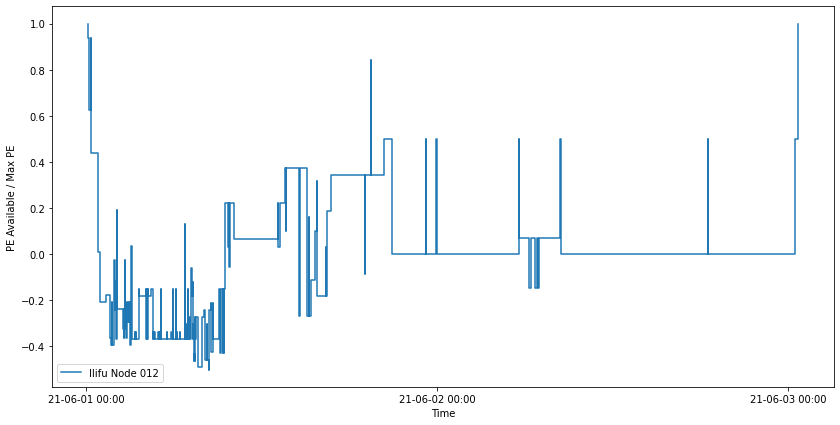

In [133]:
# Plot graph

fig, ax = plt.subplots(figsize=[14,7])

# for ax in axs.flat:
# #     ax.xaxis.set_minor_locator(mdates.AutoDateLocator(interval_multiples=True))
#     ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=4))
# #     ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(11,19,1))) # Finetune! Or make more auto!
# #     ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(9,19,3))) # Finetune! Or make more auto!
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))

ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=2, maxticks=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

## Plot 1

# ax = axs[0,0]

ax.step(df_pe_time.event_time, 
        df_pe_time.pe_avail_norm, 
        where='post', # Very nb!!
        label = f"Ilifu Node {plot_node}")

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel(r'PE Available / Max PE')

# plt.savefig(f'images/xrun_024_slurmsim_pe_time_plot.png', 
#             facecolor='w', transparent=False)

plt.show()

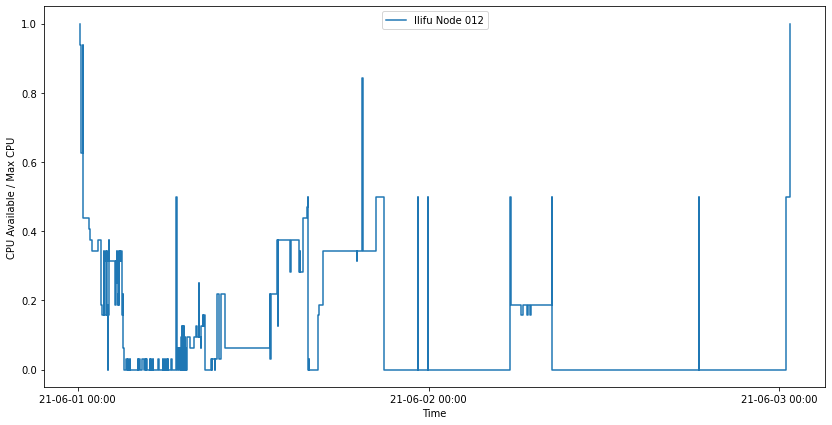

In [134]:
# Plot graph

fig, ax = plt.subplots(figsize=[14,7])

# for ax in axs.flat:
# #     ax.xaxis.set_minor_locator(mdates.AutoDateLocator(interval_multiples=True))
#     ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=4))
# #     ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(11,19,1))) # Finetune! Or make more auto!
# #     ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(9,19,3))) # Finetune! Or make more auto!
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))

ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=2, maxticks=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

## Plot 1

# ax = axs[0,0]

ax.step(df_cpu_time.event_time, 
        df_cpu_time.pe_avail_norm, 
        where='post', # Very nb!!
        label = f"Ilifu Node {plot_node}")

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel(r'CPU Available / Max CPU')

plt.savefig(f'images/ilfu_node_{plot_node}_cpuplot_only.png', 
             facecolor='w', transparent=False)

plt.show()

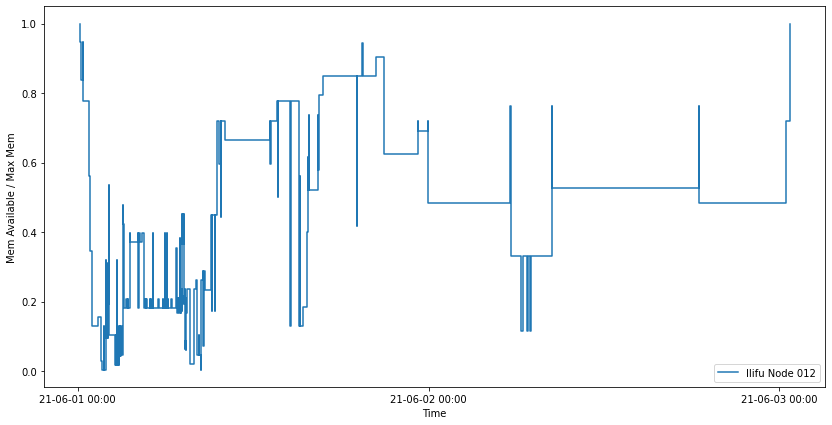

In [135]:
# Plot graph

fig, ax = plt.subplots(figsize=[14,7])

# for ax in axs.flat:
# #     ax.xaxis.set_minor_locator(mdates.AutoDateLocator(interval_multiples=True))
#     ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=4))
# #     ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(11,19,1))) # Finetune! Or make more auto!
# #     ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(9,19,3))) # Finetune! Or make more auto!
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))

ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=2, maxticks=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

## Plot 1

# ax = axs[0,0]

ax.step(df_mem_time.event_time, 
        df_mem_time.pe_avail_norm, 
        where='post', # Very nb!!
        label = f"Ilifu Node {plot_node}")

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel(r'Mem Available / Max Mem')

plt.savefig(f'images/ilfu_node_{plot_node}_memplot_only.png', 
             facecolor='w', transparent=False)


plt.show()

In [136]:
# ?ax.axhline

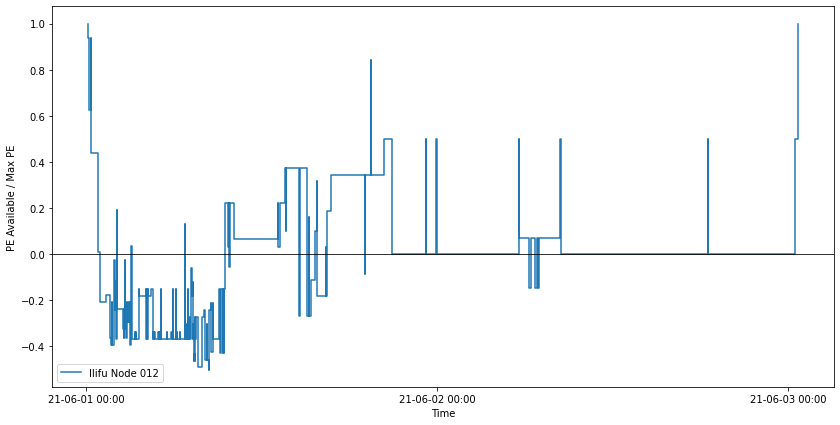

In [137]:
# Plot graph

fig, ax = plt.subplots(figsize=[14,7])

# for ax in axs.flat:
# #     ax.xaxis.set_minor_locator(mdates.AutoDateLocator(interval_multiples=True))
#     ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=4))
# #     ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(11,19,1))) # Finetune! Or make more auto!
# #     ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(9,19,3))) # Finetune! Or make more auto!
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))

ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=2, maxticks=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

## Plot 1

# ax = axs[0,0]

ax.step(df_pe_time.event_time, 
        df_pe_time.pe_avail_norm, 
        where='post', # Very nb!!
        label = f"Ilifu Node {plot_node}")

ax.axhline(y=0, color='k', lw=1, alpha=0.8)

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel(r'PE Available / Max PE')

plt.savefig(f'images/ilfu_node_{plot_node}_peplot_only.png', 
             facecolor='w', transparent=False)

plt.show()

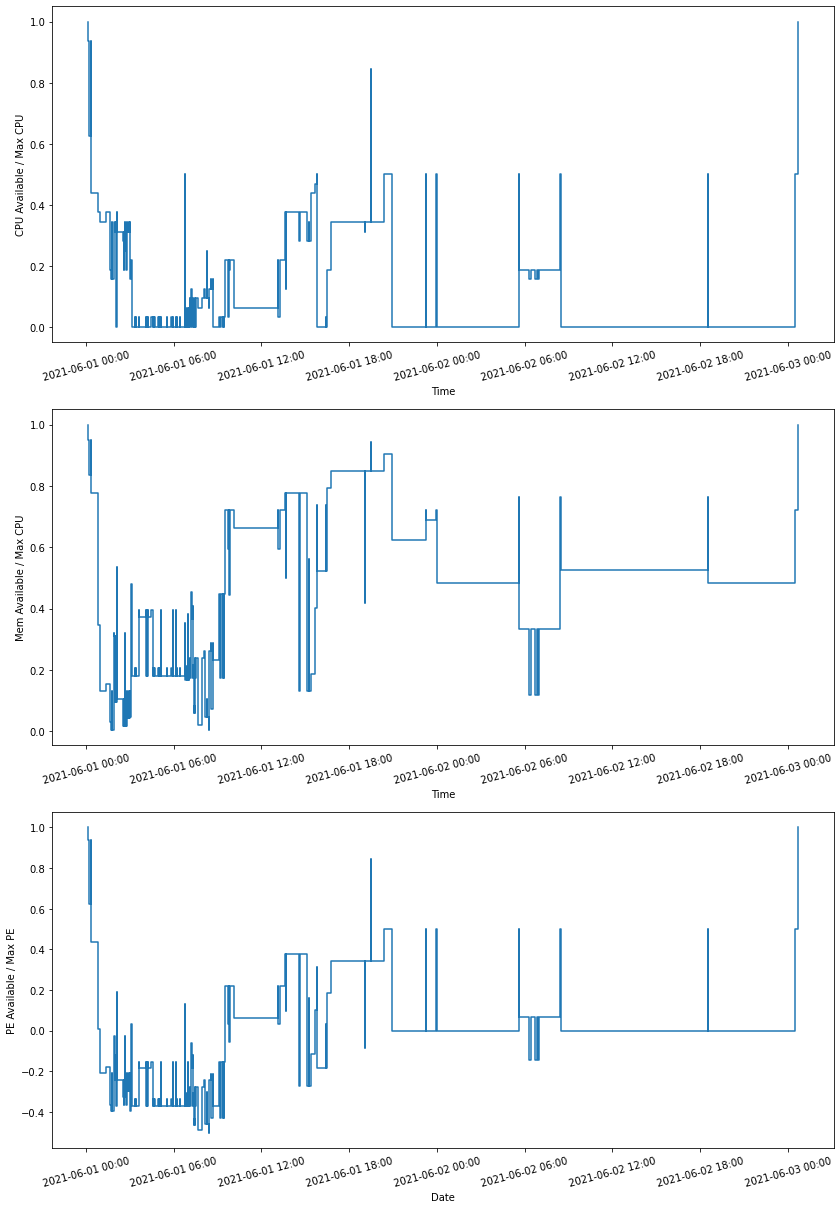

In [138]:
# Combined Plot

fig, axs = plt.subplots(ncols=1, nrows=3, figsize=[14, 21], sharex=True)

plt.draw

for ax in axs.flat:
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.tick_params(axis='x', labelrotation = 15)
#     ax.xaxis.set_minor_locator(mdates.AutoDateLocator(interval_multiples=True))
#     ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=6))
#     ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(11,19,1))) # Finetune! Or make more auto!
#     ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(9,19,3))) # Finetune! Or make more auto!
#    ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))

# Plot 1

ax = axs[0]

ax.step(df_cpu_time.event_time, 
        df_cpu_time.pe_avail_norm, 
        where='post', # Very nb!!
        label = f"Ilifu Node {plot_node}",)

# ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel(r'CPU Available / Max CPU')

# Plot 2

ax = axs[1]

ax.step(df_mem_time.event_time, 
        df_mem_time.pe_avail_norm, 
        where='post', # Very nb!!
        label = f"Ilifu Node {plot_node}")

# ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel(r'Mem Available / Max CPU')

# # Plot 3

ax = axs[2]

ax.step(df_pe_time.event_time, 
        df_pe_time.pe_avail_norm, 
        where='post', # Very nb!!
        label = f"Ilifu Node {plot_node}")

# ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel(r'PE Available / Max PE')

# Save Plot

plt.savefig(f'images/ilfu_node_{plot_node}_peplot.png', 
             facecolor='w', transparent=False)

# Show Plot
plt.show()

# Plot Buckets: Daily



In [139]:
df = pd.DataFrame({'job': pd.Categorical(['job1','job2','job3','job4']),
               'person': pd.Categorical(['p1', 'p1', 'p2','p2']),
               'start': ['2015-01-01', '2015-06-01', '2015-01-01', '2016- 01- 01'],
               'end': ['2015-07-01', '2015- 12-31', '2016-03-01', '2016-12-31']})
df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])

df

,job,person,start,end
0,job1,p1,2015-01-01,2015-07-01
1,job2,p1,2015-06-01,2015-12-31
2,job3,p2,2015-01-01,2016-03-01
3,job4,p2,2016-01-01,2016-12-31


In [140]:
# ?df.unstack

In [141]:
def make_date_range(x):
    return pd.Series(index=pd.date_range(x.start.values[0], x.end.values[0], freq='M'), data=x.job.values[0])

# Iterate through each job person combo and make an entry for each month with the job as the value
df1 = df.groupby(['job', 'person']).apply(make_date_range).unstack('person')

# remove outer level from index
df1.index = df1.index.droplevel('job')

df1

# resample each month counting only unique values
df1.resample('4MS').agg(lambda x: len(x[x.notnull()].unique()))

person,p1,p2
2015-01-01,1,1
2015-05-01,2,1
2015-09-01,1,1
2016-01-01,0,2
2016-05-01,0,1
2016-09-01,0,1


In [142]:
pd.date_range(start='1/1/2018', end='1/08/2018', freq='D')

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08'],
              dtype='datetime64[ns]', freq='D')

In [143]:
pd.interval_range(pd.to_datetime('2020/01/31 12:00'), 
                  pd.to_datetime('2020/03/01 00:00'), 
                  freq='D')

IntervalIndex([(2020-01-31 12:00:00, 2020-02-01 12:00:00], (2020-02-01 12:00:00, 2020-02-02 12:00:00], (2020-02-02 12:00:00, 2020-02-03 12:00:00], (2020-02-03 12:00:00, 2020-02-04 12:00:00], (2020-02-04 12:00:00, 2020-02-05 12:00:00] ... (2020-02-24 12:00:00, 2020-02-25 12:00:00], (2020-02-25 12:00:00, 2020-02-26 12:00:00], (2020-02-26 12:00:00, 2020-02-27 12:00:00], (2020-02-27 12:00:00, 2020-02-28 12:00:00], (2020-02-28 12:00:00, 2020-02-29 12:00:00]],
              closed='right',
              dtype='interval[datetime64[ns]]')

In [144]:
pd.to_datetime('2020/01/31 12:00')

Timestamp('2020-01-31 12:00:00')

In [145]:
pd.date_range(pd.to_datetime('2020/01/31 12:00'), pd.to_datetime('2020/02/01 03:00'), freq='D')

DatetimeIndex(['2020-01-31 12:00:00'], dtype='datetime64[ns]', freq='D')

In [146]:
freq = 'D'
pe_column = 'pe_req_node'

def make_date_range(x):
    return pd.Series(index=pd.date_range(x.start_date.values[0], x.end_date.values[0], freq=freq), data=x[pe_column].values[0])

np.random.seed(123)
df_pe_daily = (sacct_df_node[['JobID', 'start_date', 'end_date', 'pe_req_node', 'elapsed_time']]
               .query("elapsed_time > 22*3600")
               .sort_values('elapsed_time')
#                .iloc[0:1000,:]
               .sample(5)
#                .head(5)
#                .sort_values('start_date')
              )

df_pe_daily.end_date.values[0] = df_pe_daily.end_date.values[0] + pd.to_timedelta(2, "D")
df_pe_daily.elapsed_time.values[0] = df_pe_daily.elapsed_time.values[0] + 2*60*60*24

# display
(df_pe_daily
 .assign(days=lambda x: x.elapsed_time / (3600 * 24))
)

,JobID,start_date,end_date,pe_req_node,elapsed_time,days
156995,380511,2021-05-25 17:16:52,2021-05-29 04:19:47,16.00,298975.00,3.46
217976,443431,2021-05-30 17:54:03,2021-05-31 16:42:58,16.00,82135.00,0.95
141915,365371,2021-05-22 16:19:09,2021-05-24 01:42:15,16.00,120186.00,1.39
146651,370754,2021-05-24 13:11:13,2021-05-25 22:50:27,16.00,121154.00,1.40
242267,469257,2021-06-03 06:35:14,2021-06-04 10:18:08,16.00,99774.00,1.15


In [147]:
def make_date_range(x, freq='D', keep_columns='pe_req_node'):
    date_index = pd.date_range(x.start_date.values[0], x.end_date.values[0], freq=freq)
    return pd.Series(index=date_index, data=x[keep_columns].values[0])
        
(df_pe_daily
 .iloc[[0],:]
 .groupby(['JobID', 'pe_req_node'])
 .apply(make_date_range)
#  .unstack('pe_req_node')
)

,,2021-05-25 17:16:52,2021-05-26 17:16:52,2021-05-27 17:16:52,2021-05-28 17:16:52
JobID,pe_req_node,,,,
380511,16.00,16.00,16.00,16.00,16.00


In [148]:
# pd.date_range(ss, ss, freq='D')

In [149]:
df_pe_daily.to_dict()

{'JobID': {156995: '380511',
  217976: '443431',
  141915: '365371',
  146651: '370754',
  242267: '469257'},
 'start_date': {156995: Timestamp('2021-05-25 17:16:52'),
  217976: Timestamp('2021-05-30 17:54:03'),
  141915: Timestamp('2021-05-22 16:19:09'),
  146651: Timestamp('2021-05-24 13:11:13'),
  242267: Timestamp('2021-06-03 06:35:14')},
 'end_date': {156995: Timestamp('2021-05-29 04:19:47'),
  217976: Timestamp('2021-05-31 16:42:58'),
  141915: Timestamp('2021-05-24 01:42:15'),
  146651: Timestamp('2021-05-25 22:50:27'),
  242267: Timestamp('2021-06-04 10:18:08')},
 'pe_req_node': {156995: 16.0,
  217976: 16.0,
  141915: 16.0,
  146651: 16.0,
  242267: 16.0},
 'elapsed_time': {156995: 298975.0,
  217976: 82135.0,
  141915: 120186.0,
  146651: 121154.0,
  242267: 99774.0}}

In [150]:
def expand_times():
    
    # Start Date and End Date
    ss = df_pe_daily.start_date.values[0]
    ee = df_pe_daily.end_date.values[0]

    date_ss = df_pe_daily.start_date.dt.normalize().values[0]
    date_ee = df_pe_daily.end_date.dt.normalize().values[0]

    a=pd.date_range(date_ss, date_ee)

    dates_start = a.to_list()[1:]
    dates_end = dates_start

    dates_start[0] = ss
    dates_end[-1] = ee

    print(pd.DatetimeIndex(dates_start))
    print(pd.DatetimeIndex(dates_end))

    pd.DataFrame()

In [151]:
# ?pd.date_range

In [152]:
df_pe_daily.iloc[[2],:]

,JobID,start_date,end_date,pe_req_node,elapsed_time
141915,365371,2021-05-22 16:19:09,2021-05-24 01:42:15,16.00,120186.00


In [153]:
make_date_range(df_pe_daily.iloc[[2],:])

2021-05-22 16:19:09   16.00
2021-05-23 16:19:09   16.00
Freq: D, dtype: float64

In [154]:
# How to bucket stuff!! 



In [155]:
df_pe_bucket = (df_pe_time
    .query("event_type != 'init'")
    .assign(pe_time = lambda x: -1 * x.pe_delta * x.comment_runtime,
     pe_delta = lambda x: -1 * x.pe_delta)
    .loc[:, ['event_time', 
      # 'comment_runtime', 'pe_delta',
      'pe_time']]
    .set_index('event_time')
    .resample('D')
    .sum()
    .assign(pe_time = lambda x : x.pe_time.cumsum())           
                
)

df_pe_bucket

,pe_time
event_time,
2021-06-01,1910880.00
2021-06-02,1767664.00
2021-06-03,0.00
